In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Instructions for updating:
non-resource variables are not supported in the long term


Mounted at /content/gdrive


In [ ]:
dataset_path = "/content/gdrive/MyDrive/Đồ án PTDLKD/Dữ liệu Lịch sử VNM.csv"

In [ ]:
df = pd.read_csv(dataset_path)
df.head()

,Date,Price,Open,High,Low,Trading Volume,% Change
0,1/12/2017,"159,039.00","151,736.00","159,039.00","151,736.00",1.50M,4.98%
1,4/12/2017,"164,719.00","159,039.00","166,423.00","159,039.00",1.70M,3.57%
2,5/12/2017,"161,473.00","164,719.00","166,342.00","160,662.00",852.08K,-1.97%
3,6/12/2017,"158,227.00","158,227.00","159,850.00","151,898.00",1.14M,-2.01%
4,7/12/2017,"150,924.00","158,227.00","160,580.00","150,924.00",1.43M,-4.62%


In [ ]:
# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

In [ ]:
df['Price'] = df['Price'].apply(convert_str_to_number)
minmax = MinMaxScaler().fit(df.iloc[:, 1:2].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 1:2].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)

In [ ]:
train_size = int(0.7 * len(df_log))
test_size = int(0.2 * len(df_log))
val_size = len(df_log) - train_size - test_size

df_train = df_log[:train_size]
df_test = df_log[train_size:train_size+test_size]
df_val = df_log[train_size+test_size:]
df.shape, df_train.shape, df_test.shape, df_val.shape

((1381, 7), (966, 1), (276, 1), (139, 1))

In [ ]:
def encoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(
        inp,
        [
            [0, 0],
            [(filter_size[0] - 1) // 2, (filter_size[0] - 1) // 2],
            [0, 0],
            [0, 0],
        ],
    )
    conv = tf.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def decoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(inp, [[0, 0], [filter_size[0] - 1, 0], [0, 0], [0, 0]])
    conv = tf.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def glu(x):
    return tf.multiply(
        x[:, :, : tf.shape(x)[2] // 2],
        tf.sigmoid(x[:, :, tf.shape(x)[2] // 2 :]),
    )


def layer(inp, conv_block, kernel_width, n_hidden, residual = None):
    z = conv_block(inp, n_hidden, (kernel_width, 1))
    return glu(z) + (residual if residual is not None else 0)

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        kernel_size = 3,
        n_attn_heads = 16,
        dropout = 0.9,
    ):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.layers.dense(self.X, size_layer)

        e = tf.identity(encoder_embedded)
        for i in range(num_layers):
            z = layer(
                encoder_embedded,
                encoder_block,
                kernel_size,
                size_layer * 2,
                encoder_embedded,
            )
            z = tf.nn.dropout(z, keep_prob = dropout)
            encoder_embedded = z

        encoder_output, output_memory = z, z + e
        g = tf.identity(encoder_embedded)

        for i in range(num_layers):
            attn_res = h = layer(
                encoder_embedded,
                decoder_block,
                kernel_size,
                size_layer * 2,
                residual = tf.zeros_like(encoder_embedded),
            )
            C = []
            for j in range(n_attn_heads):
                h_ = tf.layers.dense(h, size_layer // n_attn_heads)
                g_ = tf.layers.dense(g, size_layer // n_attn_heads)
                zu_ = tf.layers.dense(
                    encoder_output, size_layer // n_attn_heads
                )
                ze_ = tf.layers.dense(output_memory, size_layer // n_attn_heads)

                d = tf.layers.dense(h_, size_layer // n_attn_heads) + g_
                dz = tf.matmul(d, tf.transpose(zu_, [0, 2, 1]))
                a = tf.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)

            c = tf.concat(C, 2)
            h = tf.layers.dense(attn_res + c, size_layer)
            h = tf.nn.dropout(h, keep_prob = dropout)
            encoder_embedded = h

        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = test_size
epoch = 300
dropout_rate = 0.7
future_day = test_size
learning_rate = 1e-3

In [ ]:
def forecast(index, days):
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1],
        dropout = dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
            )
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = days

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[index:index+days]

In [ ]:
y_test = forecast(train_size, test_size)

<ipython-input-8-0593352c029a>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, size_layer)
<ipython-input-8-0593352c029a>:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.layers.conv2d(
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
<ipython-input-8-0593352c029a>:22: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.layers.conv2d(
<ipython-input-8-0593352c029a>:82: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-8-0593352c029a>:83: UserWarning: `tf.laye

In [ ]:
y_val = forecast(test_size, val_size)

<ipython-input-8-0593352c029a>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, size_layer)
<ipython-input-8-0593352c029a>:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.layers.conv2d(
<ipython-input-8-0593352c029a>:22: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.layers.conv2d(
<ipython-input-8-0593352c029a>:82: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-8-0593352c029a>:83: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ =

In [ ]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
y_next_30_days = forecast(val_size, 30)

<ipython-input-8-0593352c029a>:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, size_layer)
<ipython-input-8-0593352c029a>:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.layers.conv2d(
<ipython-input-8-0593352c029a>:22: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.layers.conv2d(
<ipython-input-8-0593352c029a>:82: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-8-0593352c029a>:83: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ =

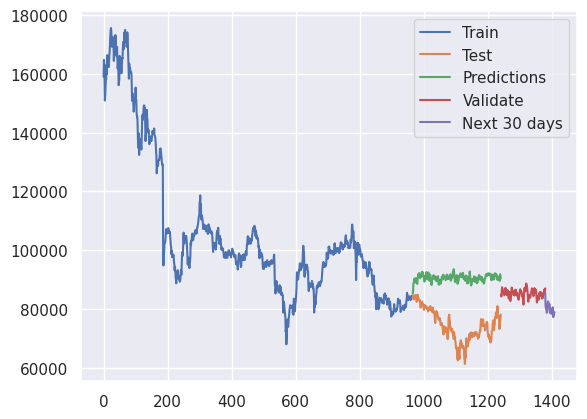

In [ ]:
plt.plot(df['Price'].iloc[:train_size], label = 'Train')
plt.plot(df['Price'].iloc[train_size:train_size+test_size], label = 'Test')
plt.plot(df_test.index, y_test, label = 'Predictions')
plt.plot(df_val.index, y_val, label = 'Validate')
plt.plot(last_data, y_next_30_days, label = 'Next 30 days')
plt.legend()


In [ ]:
# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

# Tính toán RMSE, MAPE, MDA trên tập test
actual_values = df['Price'].iloc[train_size:train_size+test_size]
test_score_rmse=np.sqrt(mean_squared_error(actual_values, y_test))
test_score_mape=mean_absolute_percentage_error(actual_values, y_test) * 100
test_score_mda=calculate_mda(actual_values, y_test)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 16954.951873132686
MAPE trên tập test là: 22.148838790740648 %
MDA trên tập test là: 42.18181818181818 %
